# MNIST Digit Recognition: A Machine Learning Case Study (Part I)

We present a comparative study of classical supervised learning approaches to handwritten digit recognition on MNIST. We consider a progression of increasingly well-specified models, starting with linear regression as an intentionally misspecified baseline and proceeding to large-margin linear classifiers and multinomial logistic regression. We then continue to dimensionality reduction by means of PCA and apply kernel methods (polynomial, RBF) to introduce non-linear decision boundaries. We investigate how the choice of objective function, representation and regularisation affects generalisation.

## Contents

1. [Introduction & Setup](#1-introduction--setup)
2. [Linear Regression Baseline](#2-linear-regression-baseline)
3. [Support Vector Machines](#3-support-vector-machines)
4. [Multinomial (Softmax) Regression](#4-multinomial-softmax-regression)
5. [Effects of Temperature Scaling](#5-effects-of-temperature-scaling)
6. [Changing Labels: Modulo-3 Classification](#6-changing-labels-modulo-3-classification)
7. [Dimensionality Reduction via PCA](#7-dimensionality-reduction-via-pca)
8. [Polynomial Feature Mapping](#8-polynomial-feature-mapping)
9. [Kernel Methods](#9-kernel-methods)
10. [Kernelised Softmax](#10-kernelised-softmax)
11. [Results Summary](#11-results-summary)


## 1. Introduction & Setup

We study supervised multiclass classification on the MNIST (Modified National Institute of Standards and Technology) dataset. Each example is a greyscale image, flattened into a vector $\mathbf{x}^{(i)} \in \mathbb{R}^{784}$, with a label $y^{(i)} \in \{0,\dots,9\}$. The learning objective is to fit a classifier $h$ that minimises the expected 0-1 loss. Model performance is reported using the empirical test error rate

$$
\epsilon_{\text{test}} = \frac{1}{n_{\text{test}}}\sum_{i=1}^{n_{\text{test}}} \mathbb{1}\{h(\mathbf{x}^{(i)}) \ne y^{(i)}\}.
$$

We do not optimise the 0–1 loss directly as it is discontinuous and non-convex, making optimisation difficult. We instead minimise (sub-)differentiable, often regularised, surrogate losses specific to each model class that proxy classification error.

### Implementation and Experimental Controls

All models in this notebook are implemented via the local project modules (`src.data`, `src.models`, `src.experiments`). For reproducibility and iteration speed, we use a `FAST_MODE` switch that shortens optimisation runs while preserving the training pipeline and evaluation protocol.


In [1]:
# Configuration
FAST_MODE = False  # Set to False for full training (slower but more accurate)

# Training iteration counts
NUM_ITERATIONS = 30 if FAST_MODE else 150
TEMP_ITERATIONS = 20 if FAST_MODE else 150

In [2]:
# Standard library imports
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# Local library imports
from src.data import get_mnist_data, plot_images
from src.experiments import (
    analyse_temperature_effects,
    run_kernelised_softmax_on_mnist_pca10,
    run_linear_regression_on_mnist,
    run_multiclass_svm_on_mnist,
    run_sklearn_svm_poly_on_pca10,
    run_sklearn_svm_rbf_on_pca10,
    run_softmax_on_mnist,
    run_softmax_on_mnist_cubic,
    run_softmax_on_mnist_eval_mod3,
    run_softmax_on_mnist_mod3,
    run_softmax_on_mnist_pca,
    run_svm_one_vs_rest_on_mnist,
)
from src.models.classical.features import (
    center_data,
    principal_components,
    project_onto_PC,
    reconstruct_PC,
)
from src.models.classical.kernel import polynomial_kernel, rbf_kernel
from src.visualisation.plots import plot_PC

# Suppress runtime warnings for log(0) in cost function
warnings.filterwarnings("ignore", category=RuntimeWarning)

plt.style.use("seaborn-v0_8-whitegrid")

### Data Loading and Qualitative Inspection

We begin by loading the MNIST training/test splits and performing a brief sanity check (dataset sizes, label support, and pixel ranges).


In [3]:
# Load the MNIST dataset
train_x, train_y, test_x, test_y = get_mnist_data()

print(f"Training set: {train_x.shape[0]:,} samples, {train_x.shape[1]} features")
print(f"Test set:     {test_x.shape[0]:,} samples")
print(f"Pixel range:  [{train_x.min():.1f}, {train_x.max():.1f}]")
print(f"Labels:       {sorted(set(train_y))}")

Training set: 60,000 samples, 784 features
Test set:     10,000 samples
Pixel range:  [0.0, 1.0]
Labels:       [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


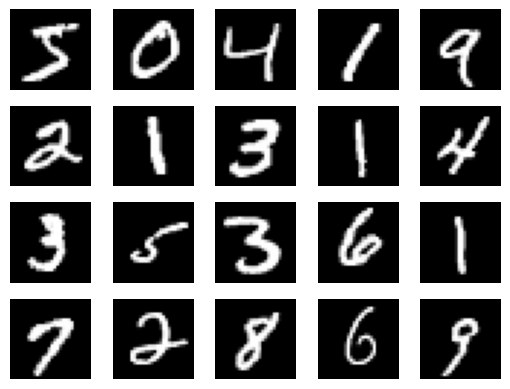

In [4]:
# Visualise sample digits
plot_images(train_x[:20])

## 2. Linear Regression Baseline

### Model: Ridge Regression

As a deliberately misspecified baseline, we treat digit IDs as real-valued targets and fit a ridge regression model. Using the augmented feature vector $\bar{\mathbf{x}} = [1,\, \mathbf{x}] \in \mathbb{R}^{d+1}$, the prediction is

$$
\hat{y} = \boldsymbol{\theta}^\top \mathbf{x} + \theta_0 \equiv \bar{\boldsymbol{\theta}}^\top \bar{\mathbf{x}}.
$$

where $\bar{\boldsymbol{\theta}} = [\theta_0,\, \boldsymbol{\theta}]$.

### Objective: Squared Error with $L_2$ Regularisation

Given training data $\{(\bar{\mathbf{x}}^{(i)}, y^{(i)})\}_{i=1}^n$, ridge regression minimises

$$
J(\bar{\boldsymbol{\theta}})
= \sum_{i=1}^n \left(\bar{\boldsymbol{\theta}}^\top \bar{\mathbf{x}}^{(i)} - y^{(i)}\right)^2
+ \lambda\,\|\bar{\boldsymbol{\theta}}\|_2^2,
$$

In closed form, this yields

$$
\bar{\boldsymbol{\theta}}
=
\left(\bar{\mathbf{X}}^\top \bar{\mathbf{X}} + \lambda \mathbf{I}\right)^{-1}
\bar{\mathbf{X}}^\top \mathbf{y},
$$

where $\bar{\mathbf{X}} \in \mathbb{R}^{n \times (d+1)}$ is the augmented design matrix formed by stacking augmented feature vectors row-wise and $\mathbf{y} \in \mathbb{R}^n$ is the vector of labels.

### Discretisation

To obtain a digit prediction, we apply an ad-hoc discretisation

$$
\tilde{y} = \mathrm{clip}\!\left(\mathrm{round}(\hat{y}),\,0,\,9\right).
$$

This baseline is informative precisely because it is inappropriate for classification:

- Label geometry is arbitrary: squared loss imposes a spurious notion of distance between class IDs.
- Objective mismatch: minimising MSE does not directly encourage correct class separation.
- No probabilistic interpretation: outputs are unbounded real numbers that are manually mapped to labels in post-processing.


In [5]:
# Run ridge regression baseline
ridge_error = run_linear_regression_on_mnist(lambda_factor=1.0)
print(f"Ridge Regression Test Error: {ridge_error:.2%}")

Ridge Regression Test Error: 76.97%


The high error rate confirms that linear regression with MSE loss is inappropriate for digit classification.


## 3. Support Vector Machines

### Model: Large-Margin Linear Classification

For binary labels $y^{(i)} \in \{-1,+1\}$, a linear classifier uses the score

$$
f(\mathbf{x}) = \boldsymbol{\theta}^\top \mathbf{x} + \theta_0,
$$

and predicts $\hat{y} = \mathrm{sign}(f(\mathbf{x}))$. The (signed) margin for example $i$ is

$$
z_i = y^{(i)} f(\mathbf{x}^{(i)}).
$$

### Objective: Soft-Margin Hinge Loss

The hinge loss penalises margin violations via

$$
\ell_{\text{hinge}}(z_i) = \max(0,\; 1 - z_i).
$$

The soft-margin SVM solves the regularised empirical risk minimisation problem

$$
\min_{\boldsymbol{\theta},\theta_0}\; \frac{1}{2}\|\boldsymbol{\theta}\|_2^2 + C\sum_{i=1}^{n}\max\!\left(0,\; 1 - y^{(i)}(\boldsymbol{\theta}^\top \mathbf{x}^{(i)} + \theta_0)\right),
$$

where $C>0$ controls the trade-off between margin size and training errors, with a smaller value of $C$ corresponding to more regularisation and a larger margin.

### Multiclass Extension

For MNIST, we consider two large-margin baselines:

1. Binary one-vs-rest reduction (digit 0 vs not-0)
2. Multiclass linear SVM

The key conceptual change from the linear regression baseline is the use of a classification-appropriate surrogate loss (hinge loss) that encourages explicit class separation.


In [6]:
# Binary SVM: Digit 0 vs. Not-0
binary_svm_error = run_svm_one_vs_rest_on_mnist(C=0.1)
print(f"Binary SVM (0 vs not-0) Test Error: {binary_svm_error:.2%}")

Binary SVM (0 vs not-0) Test Error: 0.75%


In [7]:
# Multiclass Linear SVM
multiclass_svm_error = run_multiclass_svm_on_mnist(C=0.1)
print(f"Multiclass Linear SVM Test Error: {multiclass_svm_error:.2%}")

Multiclass Linear SVM Test Error: 8.19%


We observe that the linear SVM achieves approximately 8% error on the full 10-class problem, significantly outperforming linear regression.


## 4. Multinomial (Softmax) Logistic Regression

### Model: Softmax Probabilities

For a $k$-class problem, we parameterise class scores with a weight matrix $\bar{\boldsymbol{\Theta}} \in \mathbb{R}^{k \times (d+1)}$, where row $\bar{\boldsymbol{\theta}}_j^\top$ corresponds to class $j$. Each MNIST image is a feature vector $\mathbf{x}^{(i)} \in \mathbb{R}^{d}$ (with $d=784$), and as before we include an intercept by working with the augmented vector

$$
\bar{\mathbf{x}}^{(i)} = [1,\, \mathbf{x}^{(i)}] \in \mathbb{R}^{d+1}.
$$

Define the (temperature-scaled) logits

$$
a_j^{(i)} = \frac{\bar{\boldsymbol{\theta}}_j^\top \bar{\mathbf{x}}^{(i)}}{\tau}, \qquad \tau>0,
$$

and the class probabilities via softmax:

$$
P\!\left(y^{(i)} = j \mid \bar{\mathbf{x}}^{(i)}; \bar{\boldsymbol{\Theta}}\right)
= \frac{\exp\!\left(a_j^{(i)}\right)}{\sum_{\ell=0}^{k-1}\exp\!\left(a_{\ell}^{(i)}\right)}.
$$

Smaller $\tau$ produces a more concentrated (lower-entropy) predictive distribution.

### Objective: Regularised Cross-Entropy

Let $\mathbf{y}^{(i)} \in \{0,1\}^k$ be the one-hot encoding of the label for example $i$. We minimise the regularised negative log-likelihood

$$
J(\bar{\boldsymbol{\Theta}})
= -\frac{1}{n}\sum_{i=1}^{n}\sum_{j=0}^{k-1} y^{(i)}_j\, \log P\!\left(y^{(i)} = j \mid \bar{\mathbf{x}}^{(i)}; \bar{\boldsymbol{\Theta}}\right)
\; +\; \frac{\lambda}{2}\sum_{j=0}^{k-1}\|\bar{\boldsymbol{\theta}}_j\|_2^2,
$$

and solve

$$
\min_{\bar{\boldsymbol{\Theta}}} \; J(\bar{\boldsymbol{\Theta}}).
$$

### Numerical Stability

To avoid overflow in $\exp(\cdot)$, we stabilise by subtracting the maximum logit per example. Let

$$
c^{(i)} = \max_j a_j^{(i)},
$$

then

$$
P\!\left(y^{(i)} = j \mid \bar{\mathbf{x}}^{(i)}\right)
= \frac{\exp\!\left(a_j^{(i)} - c^{(i)}\right)}{\sum_{\ell=0}^{k-1}\exp\!\left(a_{\ell}^{(i)} - c^{(i)}\right)}.
$$

### Optimisation: Gradient Descent

Training proceeds by batch gradient descent on the augmented design matrix $\bar{\mathbf{X}} \in \mathbb{R}^{n\times (d+1)}$ whose rows are $\bar{\mathbf{x}}^{(i)}$. Let

- $\mathbf{P} \in \mathbb{R}^{k\times n}$ denote the predicted probabilities, with $P_{j,i} = P(y^{(i)}=j\mid \bar{\mathbf{x}}^{(i)};\bar{\boldsymbol{\Theta}})$,
- $\mathbf{Y} \in \mathbb{R}^{k\times n}$ denote the one-hot label matrix, with $Y_{j,i}=\mathbb{1}\{y^{(i)}=j\}$.

Then the regularised gradient is

$$
\nabla_{\bar{\boldsymbol{\Theta}}} J(\bar{\boldsymbol{\Theta}})
= \frac{1}{\tau n}\, (\mathbf{P}-\mathbf{Y})\,\bar{\mathbf{X}}
\; +\; \lambda\,\bar{\boldsymbol{\Theta}}.
$$

Equivalently, for each class row $\bar{\boldsymbol{\theta}}_j$,

$$
\nabla_{\bar{\boldsymbol{\theta}}_j} J(\bar{\boldsymbol{\Theta}})
= \frac{1}{\tau n}\sum_{i=1}^n \left(p_j^{(i)} - \mathbb{1}\{y^{(i)}=j\}\right)\,\bar{\mathbf{x}}^{(i)}
\; +\; \lambda\,\bar{\boldsymbol{\theta}}_j.
$$

The explicit parameter update is

$$
\bar{\boldsymbol{\Theta}} \leftarrow \bar{\boldsymbol{\Theta}} - \alpha\,\nabla_{\bar{\boldsymbol{\Theta}}} J(\bar{\boldsymbol{\Theta}}),
$$

where $\alpha$ is the learning rate.


In [8]:
# Train softmax regression on raw pixels
theta, cost_history, softmax_error = run_softmax_on_mnist(
    temp_parameter=1.0,
    alpha=0.3,
    lambda_factor=1e-4,
    num_iterations=NUM_ITERATIONS,
)

print(f"Softmax Regression Test Error: {softmax_error:.2%}")
print(f"Final Cost: {cost_history[-1]:.4f}")

Softmax Regression Test Error: 10.05%
Final Cost: 0.4048


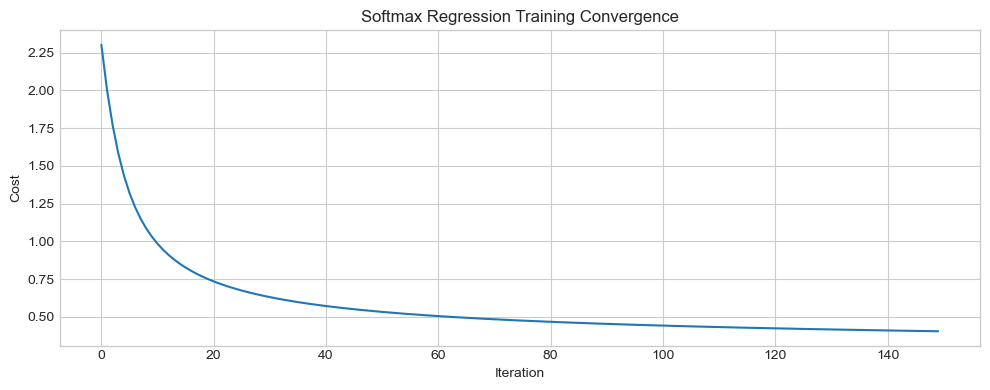

In [9]:
# Visualise training convergence
plt.figure(figsize=(10, 4))
plt.plot(cost_history)
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.title("Softmax Regression Training Convergence")
plt.tight_layout()
plt.show()

## 5. Effects of Temperature Scaling

### Limiting Behaviour

In the temperature-scaled softmax, logits are divided by $\tau>0$. For a fixed score vector $\mathbf{s} \in \mathbb{R}^k$, temperature scaling defines

$$
\mathrm{softmax}_\tau(\mathbf{s})_j = \frac{\exp(s_j/\tau)}{\sum_{\ell=0}^{k-1}\exp(s_\ell/\tau)} \;\equiv\; P\!\left(y=j\mid \mathbf{x}\right).
$$

where $\mathbf{x}$ is some input vector that produces class score $\mathbf{s}$.

As $\tau \to 0$, the distribution becomes increasingly peaked and tends to a point mass on $\arg\max_j s_j$; as $\tau \to \infty$, it converges to the uniform distribution $\mathrm{softmax}_\tau(\mathbf{s}) \to (1/k,\dots,1/k)$.

### Implications for Optimisation and Uncertainty

Temperature $\tau$ affects both training dynamics and the shape of the probability distribution:

- As the loss gradient includes a prefactor $1/\tau$, decreasing $\tau$ typically increases gradient magnitudes, leading to larger effective updates (and often larger parameter norms) for a fixed learning rate $\alpha$.
- Smaller $\tau$ sharpens the probability distribution by concentrating mass on higher-scoring classes, which reduces predictive entropy, $H$, and yields more confident predictions; a larger value of $\tau$ has the opposite effect.
- Very small $\tau$ can amplify sensitivity to small logit differences and exacerbate numerical or optimisation instability (even with max-subtraction), so we treat $\tau$ as a tunable hyperparameter.


In [10]:
# Evaluate softmax at different temperatures
temp_results = {}
for temp in [0.5, 1.0, 2.0]:
    _, _, error = run_softmax_on_mnist(
        temp_parameter=temp,
        num_iterations=TEMP_ITERATIONS,
    )
    temp_results[temp] = error
    print(f"Temperature {temp}: Test Error = {error:.2%}")

Temperature 0.5: Test Error = 8.40%
Temperature 1.0: Test Error = 10.05%
Temperature 2.0: Test Error = 12.61%


We see that lower temperature tends to produce better accuracy (up to a point), as the model becomes more decisive.


### Effect on Parameter Magnitude and Predictive Entropy

To quantify these effects beyond accuracy, we report the Frobenius norm of the learned weight matrix, $\|\bar{\boldsymbol{\Theta}}\|_F$, and the average predictive entropy on the test set. For a probability vector $\mathbf{p}$, the predictive (Shannon) entropy is given by

$$
H(\mathbf{p}) = -\sum_{j=0}^{k-1} p_j\log p_j.
$$

We sweep $\tau$ on a logarithmic grid, train each model on a fixed random subset of the training set, and report both metrics computed on the full test set.


In [11]:
# Analyse temperature effects on parameter magnitude and entropy
temp_values = np.logspace(-2, 2, 30)
temp_analysis = analyse_temperature_effects(
    temp_values=temp_values,
    sample_size=1000,
    num_iterations=TEMP_ITERATIONS,
    random_state=0,
)

print("Temperature Analysis Summary:")
print(f"Evaluated {len(temp_analysis)} temperature values")
print(f"Temperature range: [{min(temp_analysis.keys()):.3f}, {max(temp_analysis.keys()):.3f}]")

Temperature Analysis Summary:
Evaluated 30 temperature values
Temperature range: [0.010, 100.000]


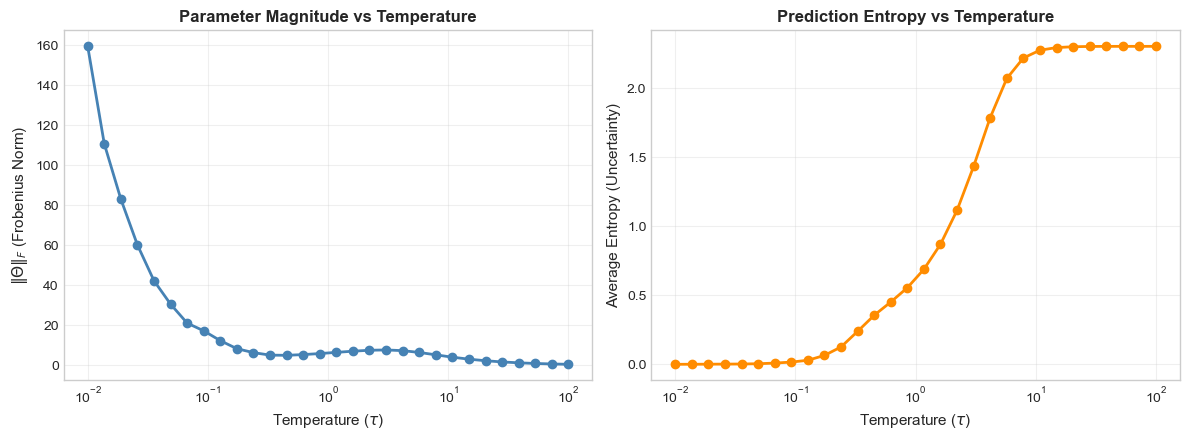

In [12]:
# Visualise the relationship on a logarithmic scale
temps = sorted(temp_analysis.keys())
magnitudes = [temp_analysis[t]["theta_magnitude"] for t in temps]
entropies = [temp_analysis[t]["avg_entropy"] for t in temps]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5))

# Parameter magnitude vs temperature
ax1.plot(temps, magnitudes, "o-", linewidth=2, markersize=6, color="steelblue")
ax1.set_xscale("log")
ax1.set_xlabel(r"Temperature ($\tau$)", fontsize=11)
ax1.set_ylabel(r"$\|\Theta\|_F$ (Frobenius Norm)", fontsize=11)
ax1.set_title("Parameter Magnitude vs Temperature", fontsize=12, fontweight="bold")
ax1.grid(True, alpha=0.3)

# Prediction entropy vs temperature
ax2.plot(temps, entropies, "o-", linewidth=2, markersize=6, color="darkorange")
ax2.set_xscale("log")
ax2.set_xlabel(r"Temperature ($\tau$)", fontsize=11)
ax2.set_ylabel("Average Entropy (Uncertainty)", fontsize=11)
ax2.set_title("Prediction Entropy vs Temperature", fontsize=12, fontweight="bold")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

We observe that decreasing temperature increases parameter magnitudes while reducing predictive entropy, yielding sharper distributions. At very low temperatures, models can become overconfident and numerically unstable, whereas very high temperatures drive predictions towards near-uniform, uninformative outputs.


## 6. Changing Labels: Modulo-3 Classification

### Problem Reformulation

To probe how label structure interacts with visual similarity, we construct a coarser classification task by mapping the original digit label $y \in \{0,\dots,9\}$ to

$$
y_{\bmod 3} = y \bmod 3 \in \{0,1,2\}.
$$

This creates three equivalence classes (e.g., $\{0,3,6,9\}$), which are not necessarily visually homogeneous.

### Evaluation Protocols

We compare two approaches:

1. Post-hoc reduction: train a standard 10-class model, predict $\hat{y}$, then output $\hat{y} \bmod 3$.
2. Direct training: train a 3-class softmax model directly on $y_{\bmod 3}$.

Both are evaluated with the same test-error metric, but they induce different inductive biases: the first retains fine-grained digit structure during training, whereas the second forces the model to learn features across visually dissimilar digits that share the same remainder.


In [13]:
# Approach 1: Train 10-class model, evaluate mod 3
_, _, softmax_error_mod3 = run_softmax_on_mnist_eval_mod3(
    temp_parameter=1.0,
    num_iterations=NUM_ITERATIONS,
)
print(f"Mod-3 error (using 10-class model): {softmax_error_mod3:.2%}")

Mod-3 error (using 10-class model): 7.68%


In [14]:
# Approach 2: Retrain directly on mod-3 labels
_, _, mod3_retrain_error = run_softmax_on_mnist_mod3(
    temp_parameter=1.0,
    num_iterations=NUM_ITERATIONS,
)
print(f"Mod-3 error (retrained on mod-3 labels): {mod3_retrain_error:.2%}")

Mod-3 error (retrained on mod-3 labels): 18.81%


It can be seen that retraining directly on mod-3 labels performs worse than using the original model. This is because digits with the same remainder (e.g., 2, 5, 8) are significantly visually dissimilar, resulting in a more difficult task to find common features for each equivalence class.


## 7. Dimensionality Reduction via PCA

### Principal Component Analysis

Let $\mathbf{X} \in \mathbb{R}^{n\times d}$ denote the data matrix with rows $\mathbf{x}^{(i)}$. PCA begins by centering the data, $\widetilde{\mathbf{X}} = \mathbf{X} - \mathbb{1}\boldsymbol{\mu}^\top$, where $\boldsymbol{\mu}$ is the feature-wise mean. The principal components are the eigenvectors of the sample covariance matrix

$$
\mathbf{\Sigma} = \frac{1}{n - 1}\widetilde{\mathbf{X}}^\top \widetilde{\mathbf{X}}.
$$

Let $\mathbf{V}_k \in \mathbb{R}^{d\times k}$ contain the top-$k$ eigenvectors (by decreasing eigenvalue).

### Projection and Reconstruction

The $k$-dimensional representation of an input is the orthogonal projection

$$
\mathbf{z} = (\mathbf{x}-\boldsymbol{\mu})^\top \mathbf{V}_k.
$$

An approximate reconstruction in the original space is

$$
\hat{\mathbf{x}} = \boldsymbol{\mu} + \mathbf{V}_k\,\mathbf{z}.
$$

### Rationale in This Setting

For MNIST, PCA offers a controlled way to reduce dimensionality (784 pixels) while preserving the key variability within the data. In the following, we use PCA features to (i) accelerate optimisation and (ii) provide low-dimensional inputs for explicit non-linear feature maps and kernel methods in later sections.


In [15]:
# Compute principal components for visualisation
train_x_centered, feature_means = center_data(train_x)
pcs = principal_components(train_x_centered)

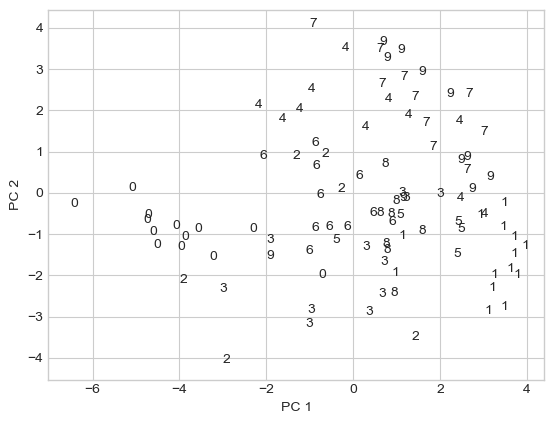

In [16]:
# Visualise first 100 training images in 2D PCA space
plot_PC(train_x[:100], pcs, train_y[:100], feature_means)

### PCA Reconstructions

To build intuition for what PCA retains and discards, we reconstruct images using only the first $k$ principal components. This provides a qualitative view of the bias introduced by dimensionality reduction: low-variance directions (often capturing fine detail and noise) are removed, while high-variance stroke-level structure is preserved.


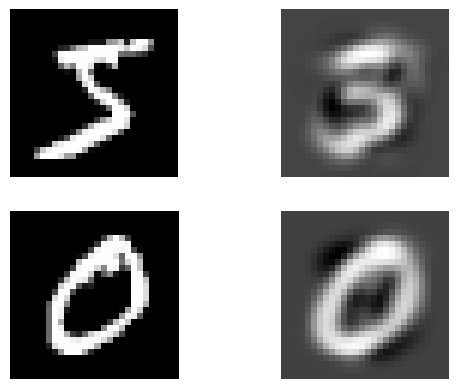

In [17]:
# Reconstruct the first two training images from PCA(18)
train_pca18_first2 = project_onto_PC(train_x[:2], pcs, n_components=18, feature_means=feature_means)

recon_0 = reconstruct_PC(train_pca18_first2[0], pcs, n_components=18, feature_means=feature_means)
recon_1 = reconstruct_PC(train_pca18_first2[1], pcs, n_components=18, feature_means=feature_means)

# Order: original0, recon0, original1, recon1
comparison = np.vstack([train_x[0], recon_0, train_x[1], recon_1])
plot_images(comparison)

In [18]:
# Train softmax on 18-dimensional PCA features
_, pca_cost_history, pca_error, _ = run_softmax_on_mnist_pca(
    n_components=18,
    temp_parameter=1.0,
    num_iterations=NUM_ITERATIONS,
)
print(f"Softmax with 18D PCA features: Test Error = {pca_error:.2%}")

Softmax with 18D PCA features: Test Error = 14.74%


Observe that with only 18 features (2.3% of the original 784) we achieve comparable performance to modelling on the full feature space.


## 8. Polynomial Feature Mapping

### Non-Linear Representations

Linear classifiers on raw pixels can underfit the non-linear structure of digit manifolds. One remedy is to map inputs through a non-linear feature map $\phi(\cdot)$ and then fit a linear model in the expanded space.

### Inhomogeneous Polynomial Feature Map

An inhomogeneous degree-$p$ polynomial feature map is defined implicitly via its associated kernel:

$$
\phi(\mathbf{x})^\top \phi(\mathbf{x}') \;=\; \left(\mathbf{x}^\top \mathbf{x}' + 1\right)^p.
$$

This kernel corresponds to an explicit feature representation containing all monomials in $d$ variables of total degree at most $p$ (including a constant term). The resulting feature-space dimension is

$$
D(d,p) \;=\; \sum_{r=0}^{p} \binom{d+r-1}{r} \;=\; \binom{d+p}{p}.
$$

Thus, $D(d,p)$ grows combinatorially with $d$ and $p$, making explicit expansion infeasible for high-dimensional inputs (e.g., raw MNIST pixels with $d=784$) even for moderate $p$.

### Practical Construction for MNIST

To keep computation tractable, we adopt a two-stage pipeline:

1. Reduce dimension to 10 via PCA (retaining dominant variance directions).
2. Apply cubic expansion to the 10D representation.
3. Train softmax regression on the resulting non-linear features.

This isolates the benefit of non-linearity while keeping training time and memory usage manageable.


In [19]:
# Train softmax on cubic features of 10D PCA representation
_, cubic_cost_history, cubic_error, _ = run_softmax_on_mnist_cubic(
    temp_parameter=1.0,
    num_iterations=NUM_ITERATIONS,
)
print(f"Softmax with Cubic(PCA-10) features: Test Error = {cubic_error:.2%}")

Softmax with Cubic(PCA-10) features: Test Error = 8.40%


It can be seen that non-linear features significantly improves the classification accuracy.


## 9. Kernel Methods

### The Kernel Trick

Many non-linear feature maps $\phi(\mathbf{x})$ yield linear models in feature space but are computationally expensive to represent explicitly. Kernel methods avoid explicit expansion by defining an inner product

$$
K(\mathbf{x},\mathbf{x}') = \phi(\mathbf{x})^\top\phi(\mathbf{x}'),
$$

and expressing algorithms solely in terms of pairwise similarities. In practice, this replaces feature vectors with the Gram (kernel) matrix $\mathbf{K} \in \mathbb{R}^{n\times n}$, where $\mathbf{K}_{i,j}=K(\mathbf{x}^{(i)},\mathbf{x}^{(j)})$.

### Polynomial Kernel

A degree-$p$ polynomial kernel is

$$
K_{\text{poly}}(\mathbf{x},\mathbf{x}') = \left(\mathbf{x}^\top \mathbf{x}' + c\right)^p, \qquad c\ge 0,\; p\in\mathbb{N}.
$$

This corresponds to an explicit expansion containing monomials up to degree $p$ (with cross-terms), enabling curved decision boundaries while keeping computation in the original space.

### RBF (Gaussian) Kernel

The radial basis function (RBF) kernel is

$$
K_{\text{RBF}}(\mathbf{x},\mathbf{x}') = \exp\left(-\gamma\,\|\mathbf{x}-\mathbf{x}'\|_2^2\right), \qquad \gamma>0.
$$

It induces an infinite-dimensional feature space and can represent highly flexible boundaries. In later experiments, we apply kernels to PCA-reduced features to control scale and improve numerical behaviour.

Below we illustrate this on on small samples for the cubic and RBF kernels.


In [20]:
# Demonstrate kernel computation on small samples
sample_x = train_x[:5]

# Polynomial kernel (degree 3)
poly_K = polynomial_kernel(sample_x, sample_x, c=1, p=3)
print("Polynomial Kernel (5x5 sample):")
print(poly_K)

Polynomial Kernel (5x5 sample):
[[7.6951419e+05 1.6050194e+05 4.9556553e+03 1.6572596e+04 2.7425990e+04]
 [1.6050194e+05 1.1249299e+06 5.6285366e+03 1.2298990e+04 5.2768949e+04]
 [4.9556553e+03 5.6285366e+03 2.1391533e+05 7.1060632e+02 6.4282290e+03]
 [1.6572596e+04 1.2298990e+04 7.1060632e+02 2.0485122e+05 1.5190440e+04]
 [2.7425990e+04 5.2768949e+04 6.4282290e+03 1.5190440e+04 4.6830328e+05]]


In [21]:
# RBF kernel
rbf_K = rbf_kernel(sample_x, sample_x, gamma=0.001)
print("RBF Kernel (5x5 sample):")
print(np.round(rbf_K, 4))

RBF Kernel (5x5 sample):
[[1.     0.9167 0.8893 0.9052 0.8967]
 [0.9167 1.     0.8796 0.8898 0.8988]
 [0.8893 0.8796 1.     0.904  0.9046]
 [0.9052 0.8898 0.904  1.     0.9166]
 [0.8967 0.8988 0.9046 0.9166 1.    ]]


In [22]:
# SVM with polynomial kernel on 10D PCA features
poly_svm_error = run_sklearn_svm_poly_on_pca10(degree=3)
print(f"Polynomial SVM (degree 3) on PCA-10: Test Error = {poly_svm_error:.2%}")

Polynomial SVM (degree 3) on PCA-10: Test Error = 7.34%


In [23]:
# SVM with RBF kernel on 10D PCA features
rbf_svm_error = run_sklearn_svm_rbf_on_pca10()
print(f"RBF SVM on PCA-10: Test Error = {rbf_svm_error:.2%}")

RBF SVM on PCA-10: Test Error = 6.36%


It is clear that kernel SVMs achieve the best performance, with RBF slightly outperforming polynomial. The RBF kernel's infinite-dimensional feature space provides exceptional flexibility for complex decision boundaries.


## 10. Kernelised Softmax

### Softmax in a Reproducing Kernel Hilbert Space

Kernelisation extends multinomial logistic regression by replacing the linear score $\boldsymbol{\theta}_j^\top\mathbf{x}$ with a function in the span of kernel evaluations. For each class $j$, we model the score as

$$
f_j(\mathbf{x}) = \sum_{i=1}^{n} \alpha_{j,i}\, K(\mathbf{x}^{(i)}, \mathbf{x}),
$$

where $\alpha_{j,i}$ are coefficients and $K$ is a positive semidefinite kernel (e.g., RBF). This is equivalent to applying softmax regression in the implicit feature space induced by $K$.

### Implementation via the Gram Matrix

Let $\mathbf{K}_{\text{train}} \in \mathbb{R}^{n\times n}$ be the Gram matrix over training inputs, with $\left(\mathbf{K}_{\text{train}}\right)_{i,j} = K(\mathbf{x}^{(i)}, \mathbf{x}^{(j)})$ and let $\mathbf{K}_{\text{test}} \in \mathbb{R}^{n_{\text{test}}\times n}$ be the cross-kernel matrix between test and training inputs, with $\left(\mathbf{K}_{\text{test}}\right)_{p,j} = K(\mathbf{x}_{\text{test}}^{(p)}, \mathbf{x}^{(j)})$. We can reuse the standard softmax routine by treating $\mathbf{K}_{\text{train}}$ as the feature matrix and learning a weight matrix over its columns.

### Computational Considerations

This approach scales quadratically in the number of training points (memory and time for forming and using $\mathbf{K}_{\text{train}}$), i.e., $O(n^2)$. We therefore demonstrate kernelised softmax on a restricted subset of MNIST (after PCA) to make the experiment tractable while retaining the qualitative behaviour of the model.

We subsample 12,000 training examples uniformly across classes to control the $O(n^2)$ memory and compute costs of forming and using the Gram matrix.

We now run a small-scale kernelised softmax experiment using an RBF kernel on PCA-10 features and report the resulting test error.


In [24]:
# Kernelised softmax on PCA-10 features (RBF kernel) using a class-balanced subset.

# Demonstration as the Gram-matrix representation scales as O(n^2).
KERNEL_SOFTMAX_SUBSET = 1000 if FAST_MODE else 12000
KERNEL_SOFTMAX_ITERS = 50 if FAST_MODE else 600

_, _, kernel_softmax_error, _ = run_kernelised_softmax_on_mnist_pca10(
    subset_size=KERNEL_SOFTMAX_SUBSET,
    kernel="rbf",
    gamma=0.1,
    temp_parameter=0.7,
    alpha=0.4,
    lambda_factor=5e-8,
    num_iterations=KERNEL_SOFTMAX_ITERS,
    random_state=0,
)

print(f"Kernelised Softmax (RBF, PCA-10, n={KERNEL_SOFTMAX_SUBSET}): Test Error = {kernel_softmax_error:.2%}")

Kernelised Softmax (RBF, PCA-10, n=12000): Test Error = 8.93%


Kernelised softmax can model highly non-linear boundaries, but the quadratic scaling makes it practical only on smaller subsets or with approximate kernels.


## 11. Results Summary

### Evaluation Protocol

All methods below are evaluated on the held-out MNIST test set and summarised by the test error rate $\epsilon_{\text{test}}$. The results include a ridge-regression baseline, linear and kernel Support Vector Machines (SVMs) and several variants of multinomial logistic regression (softmax).

To aid interpretation, we distinguish between representation changes within a fixed classifier family and changes to the classifier family itself. Specifically:

- Softmax variants: The raw pixels, PCA-18, and Cubic(PCA-10) models utilise multinomial logistic regression, differing only in the input feature space.
- SVM entries: These models (binary one-vs-rest, multiclass linear, polynomial kernel, and RBF kernel) optimise a large-margin hinge-loss objective. For the kernelised SVMs, we fixed the representation to 10D PCA to maintain computational tractability.
- Kernelised Softmax: We report the RBF (PCA-10) variant as a small-scale demonstration. Due to the complexity of the Gram matrix construction, this model was trained on a reduced subset ($n=12000$) of the data.

### Performance Comparison

The table and plot below aggregate the error rates obtained across the modelling configurations considered.

_Note:_ The kernelised softmax experiment is a small-scale demonstration (subset training and Gram-matrix computation), so its number is not directly comparable to full-dataset baselines.


In [25]:
# Compile results
results = {
    "Ridge Regression (baseline)": ridge_error,
    "Binary SVM (0 vs not-0)": binary_svm_error,
    "Multiclass Linear SVM": multiclass_svm_error,
    "Softmax (raw pixels)": softmax_error,
    "Softmax (PCA-18)": pca_error,
    "Softmax (Cubic PCA-10)": cubic_error,
    "Polynomial SVM (PCA-10)": poly_svm_error,
    "RBF SVM (PCA-10)": rbf_svm_error,
    f"Kernelised Softmax (RBF, PCA-10, n={KERNEL_SOFTMAX_SUBSET})": kernel_softmax_error,
}

# Display as formatted table
print("\n" + "=" * 63)
print(f"{'Method':<41} {'Error Rate':>10} {'Accuracy':>10}")
print("=" * 63)
for method, error in results.items():
    accuracy = 1 - error
    print(f"{method:<41} {error:>10.2%} {accuracy:>9.2%}")
print("=" * 63)


Method                                    Error Rate   Accuracy
Ridge Regression (baseline)                   76.97%    23.03%
Binary SVM (0 vs not-0)                        0.75%    99.25%
Multiclass Linear SVM                          8.19%    91.81%
Softmax (raw pixels)                          10.05%    89.95%
Softmax (PCA-18)                              14.74%    85.26%
Softmax (Cubic PCA-10)                         8.40%    91.60%
Polynomial SVM (PCA-10)                        7.34%    92.66%
RBF SVM (PCA-10)                               6.36%    93.64%
Kernelised Softmax (RBF, PCA-10, n=12000)      8.93%    91.07%


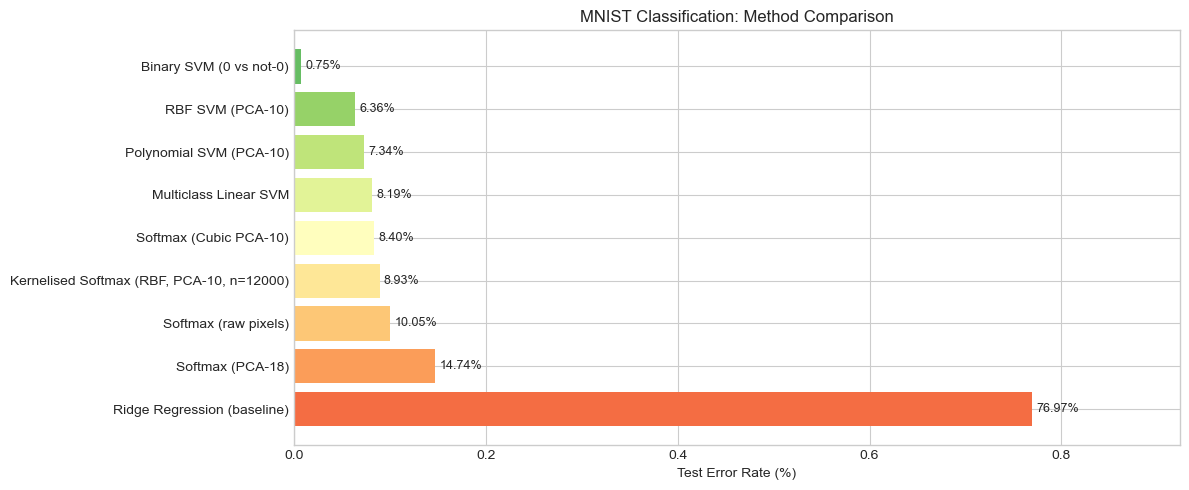

In [26]:
# Visualise results
items = sorted(results.items(), key=lambda kv: kv[1])
methods = [m for m, _ in items]
errors = np.array([err for _, err in items])

fig, ax = plt.subplots(figsize=(12, 5))

cmap = mpl.colormaps["RdYlGn_r"]
colors = cmap(np.linspace(0.2, 0.8, len(methods)))

bars = ax.barh(methods, errors, color=colors)

ax.set(
    xlabel="Test Error Rate (%)",
    title="MNIST Classification: Method Comparison",
    xlim=(0, errors.max() * 1.2),
)
ax.invert_yaxis()

ax.bar_label(bars, labels=[f"{err:.2%}" for err in errors], padding=3, fontsize=9)

fig.tight_layout()
plt.show()

### Discussion of Results

1. Objective–task alignment matters. Treating class labels as continuous values and optimising mean-squared error is poorly matched to multiclass classification; large-margin objectives (hinge loss) and probabilistic objectives (cross-entropy) provide a substantially stronger inductive bias for classification.

2. Temperature controls confidence and learning dynamics. In temperature-scaled softmax, decreasing $\tau$ sharpens the predictive distribution and typically increases gradient magnitudes; empirical sweeps help identify regimes that balance accuracy and numerical stability.

3. Representation and optimisation are coupled. Dimensionality reduction via PCA preserves much of the discriminative structure while reducing computational cost, enabling faster optimisation and making subsequent non-linear approaches more tractable.

4. Non-linearity improves separability. Explicit polynomial feature maps and kernel methods yield sizeable gains over purely linear decision functions by capturing higher-order interactions between pixels.

5. Kernel choice encodes inductive bias. Polynomial kernels correspond to finite-order interactions, whereas RBF kernels act as infinite-dimensional feature maps, yielding more malleable decision boundaries when appropriately tuned.


## Conclusion

In this notebook, we used MNIST as a controlled environment to compare classical supervised learning methods and to study two factors of model generalisation: what we optimise and how we represent the data.

On the optimisation side, replacing squared-error regression with classification-oriented losses yields significant gains in test accuracy. Large-margin models improve decision boundaries by encouraging explicit class separation, while softmax-based approaches provide a probabilistic view that better matches the multiclass classification task. The choice of representation affects both computational viability and accuracy considerably. PCA offers an effective compression that reduces computational demands without discarding the key variability within the data, while non-linear expansions, such as polynomial features and kernels, increase separability when linear models are insufficient.

We note that classical performance gains typically come from either tightening the link between the objective/loss and task, or reshaping the input space to allow for easier learning. The best results are achieved when both are addressed simultaneously.
